In [1]:
################################## 1. Load packages, define dc, match gdf and load linescan images. 

from mpl_toolkits.mplot3d import Axes3D #to plot in 3D
from matplotlib import colors           #extra colour representations
from matplotlib import cm               #extra colour representations
import cv2                              #to perform more complex manipulations on arrays

%matplotlib inline
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime

from datacube import Datacube
import matplotlib.pyplot as plt

sys.path.append("../scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize
import re

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Define dc!
dc = Datacube(app="Masking")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [3]:
# idname!
#idname = pd.read_csv('cleanclean.csv', quotechar = '"')
#idname

In [4]:
### GDF

vector_file = 'resources/fire_boundaries.shp'
gdf = gpd.read_file(vector_file)
def clean_name(name):
    if name is None:
        res = None
    else:
        if name.upper()[-4::] == ".JPG":
            res = name.upper()[:-4].replace(' ','_')
        else:
            res = name.upper().replace(' ','_')
    return res

gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
gdf.dtUTC = gdf.apply(lambda row: datetime.strptime(row.dtUTC, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.dtLocal = gdf.apply(lambda row: datetime.strptime(row.dtLocal, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf['Composite'] = gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)


/env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [5]:
## Linescan datasets!
linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))
linescan_datasets = pd.Series(linescan_datasets)

# Test1

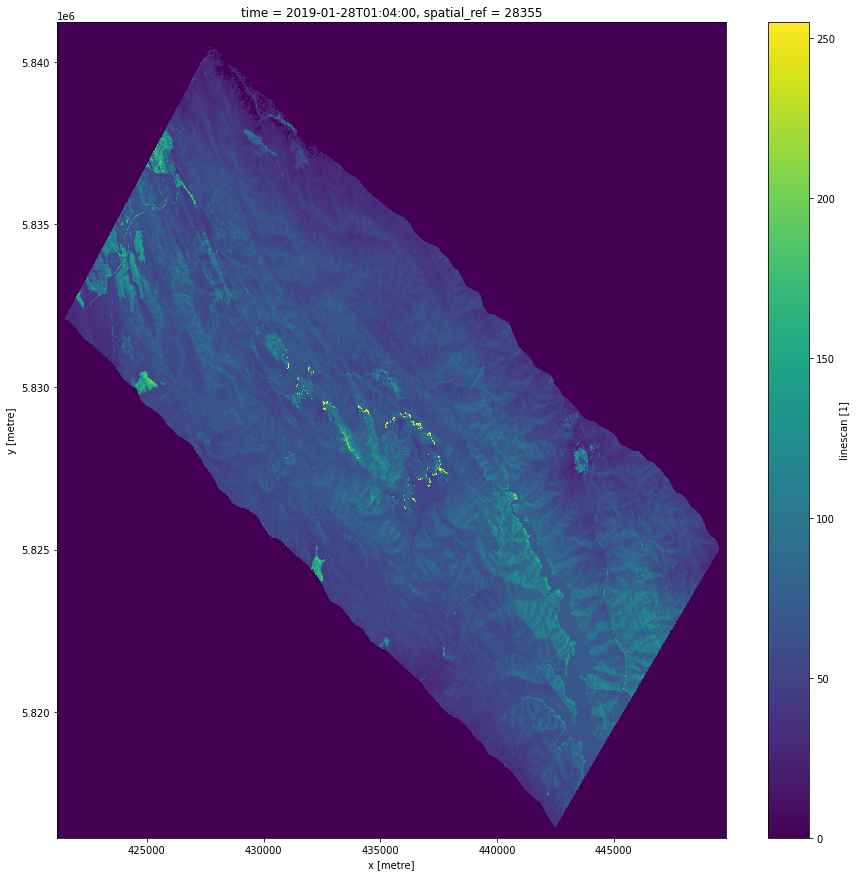

In [6]:

####### Create mask for the first test image. 
# 1. Plot test image
# 2. Find the closest image from train set()
# 3. Rasterize the train image
# 4. Extract points where is brighter than 150 from test data
# 5. Overlap the train image on train data.
# 6. Mask the overlapped image to get the prediction
# 7. Extract the required points for test set


## 1. Plot Test 1 image time: 19-01-28 1:40, x=(4100000, 4500000) and y=(58200, 58400)
ob2  = gdf[gdf.SourceNameClean == 'JORDAN_235_P1_201901281204_MGA94_55']
src2 = dc.load(product='linescan', id=linescan_datasets[32].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src2.linescan.plot(ax=ax)

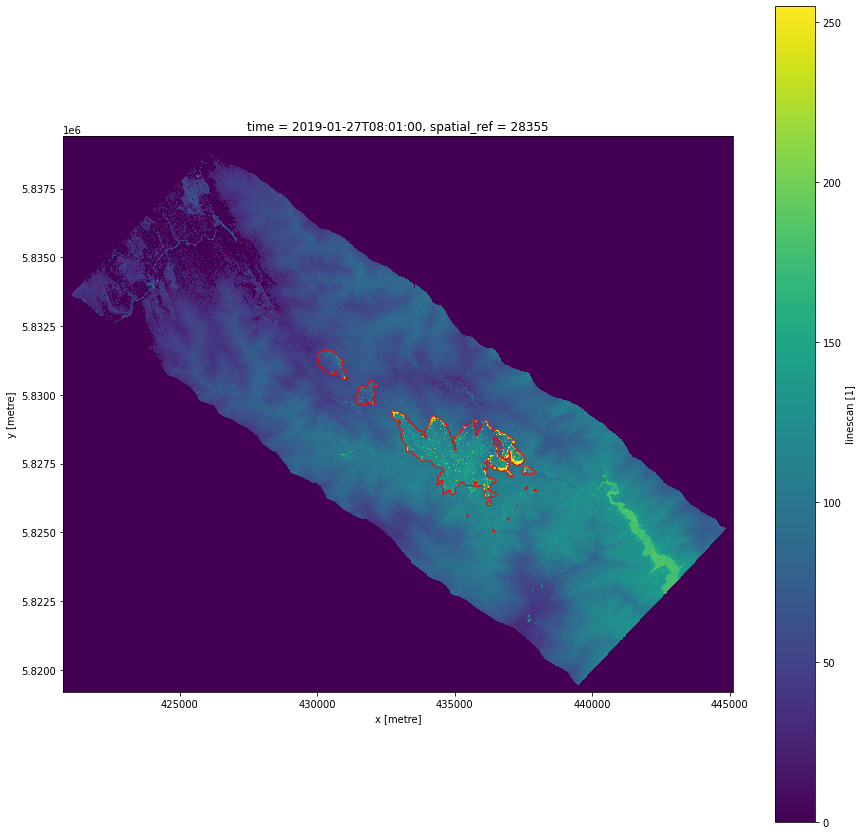

In [7]:
# 2. Find the closest time and place from training data. x=(58200, 58375), y=(425000, 445000), time: 19-01-27 08:01
ob1  = gdf[gdf.SourceNameClean == 'JORDAN_234_P1_201901271901_MGA94_55']
src1 = dc.load(product='linescan', id=linescan_datasets[31].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src1.linescan.plot(ax=ax)
ob1.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

In [8]:

# 3. Rasterize the train image

tgt = xr_rasterize(gdf=ob1, da=src1)
rgb_mask1=tgt*255
src1['rgb_mask1']=rgb_mask1


Rasterizing to match xarray.DataArray dimensions (2022, 2435)


In [9]:

# 4. Extract points where is brighter than 150 from test data

lowerBound=150
upperBound=255
#create the mask over the top of our original image
rgb_mask2 = cv2.inRange(src2.linescan.values[0],lowerBound,upperBound)

colname = src2.x.values
rowname = src2.y.values
rgb_mask2 = pd.DataFrame(rgb_mask2, index = rowname, columns = colname)
rgb_mask2.shape

(2507, 2870)

In [10]:
# 5. Overlap the train image on train data.

rgb_mask2.index.name = 'y'
rgb_mask2.columns.name = 'x'
src2['rgb_mask2'] = rgb_mask2

dftest=pd.concat([src1.to_dataframe().reset_index(), src2.to_dataframe().reset_index()], ignore_index=True, sort=False)
dftest['rgb_mask3']=np.fmax(dftest.loc[:,'rgb_mask1'], dftest.loc[:,'rgb_mask2'])
newdf=dftest.drop(columns=['time','linescan','spatial_ref', 'rgb_mask1', 'rgb_mask2'], axis=1)
dates = '2019-01-27~28'
x = newdf.x
y = newdf.y
rgb_mask = newdf.rgb_mask3
df_multiindex = pd.DataFrame({'date': dates,
                              'x': x,
                              'y': y,
                              'rgb_mask': rgb_mask})
df_multiindex = df_multiindex.set_index(['date', 'x','y'])
rgb_mask=df_multiindex[~df_multiindex.index.duplicated()].to_xarray()

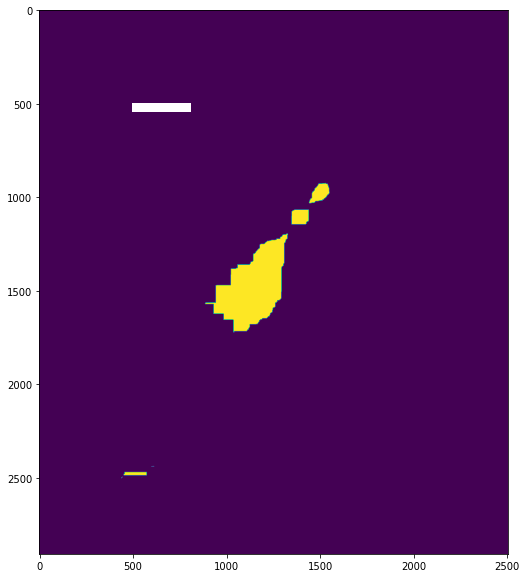

In [11]:
# 6. Mask the overlapped image to get the prediction

#establish dialation and contraction parameters
kernelOpen=np.ones((2,2)) # try it yourself!
kernelClose=np.ones((500,500))      

#denoise the pixels
maskOpen=cv2.morphologyEx(rgb_mask.rgb_mask[0].values,cv2.MORPH_OPEN,kernelOpen)

#plot the denoised pixels
#join the pxels together
maskClose=cv2.morphologyEx(maskOpen,cv2.MORPH_CLOSE,kernelClose)

fig = plt.figure(figsize=(20, 10))
plt.imshow(maskClose)
plt.show()
#establish dialation and contraction parameters

In [12]:
# 7. Extract the required points for test set
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')
fnames = test.label.unique()
fnames

array(['JORDAN_235_P1_201901281204_MGA94_55',
       'JORDAN_294_P1_201902011150_MGA94_55',
       'WALHALLA_313_P1_201902020733_MGA94_55',
       'WALHALLA_353_P1_201902031625_MGA94_55',
       'MACALISTER91_648_P1_201903070444_MGA94_55'], dtype=object)

In [13]:
## mask: the final mask that we will submit
mask = maskClose/255
our_mask = rgb_mask.rgb_mask
our_mask.values[0] = mask
# The test set we are processing: 'JORDAN_235_P1_201901281204_MGA94_55'
file_stem='JORDAN_235_P1_201901281204_MGA94_55'
# iterate over the coordinates that are required for testing in the current linescan file
for idx, ob in test.loc[test.label==file_stem].iterrows():
    result_tf = our_mask.sel(x=ob.x, y=ob.y, method='nearest').values[0]
    result_10 = int(result_tf == True)
    test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10

# Test2

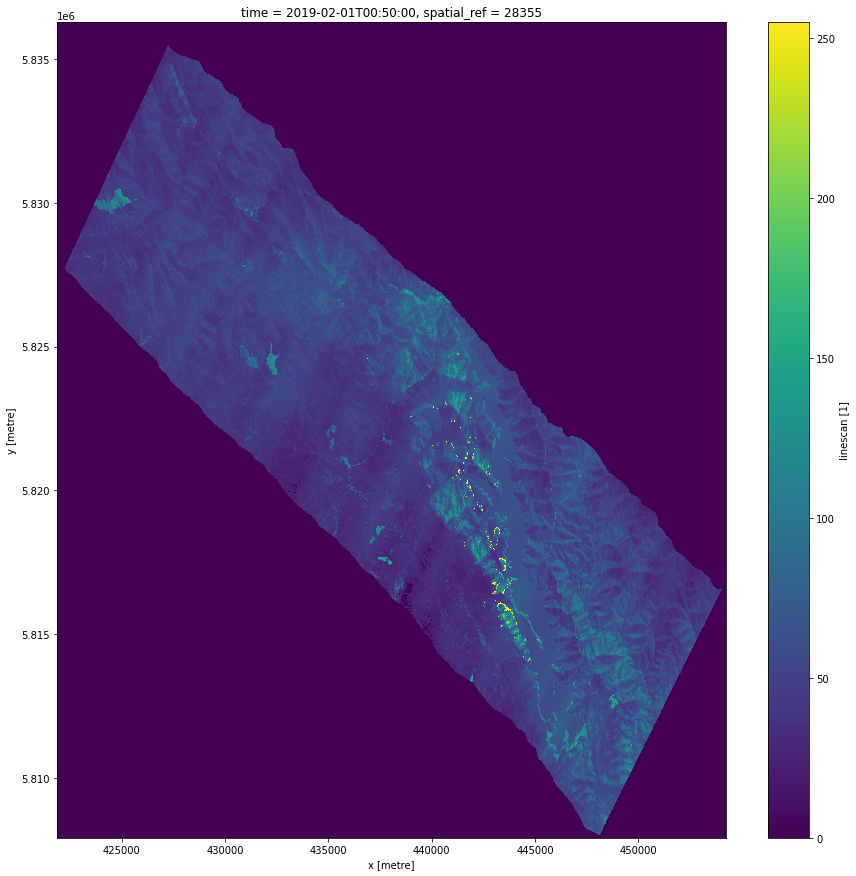

In [14]:
####### Create mask for the first test image. 
# 1. Plot test image
# 2. Find the closest image from train set()
# 3. Rasterize the train image
# 4. Extract points where is brighter than 150 from test data
# 5. Overlap the train image on train data.
# 6. Mask the overlapped image to get the prediction
# 7. Extract the required points for test set

# 1. Plot test image
ob2  = gdf[gdf.SourceNameClean == 'JORDAN_294_P1_201902011150_MGA94_55']
src2 = dc.load(product='linescan', id=linescan_datasets[37].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src2.linescan.plot(ax=ax)
#ob1.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

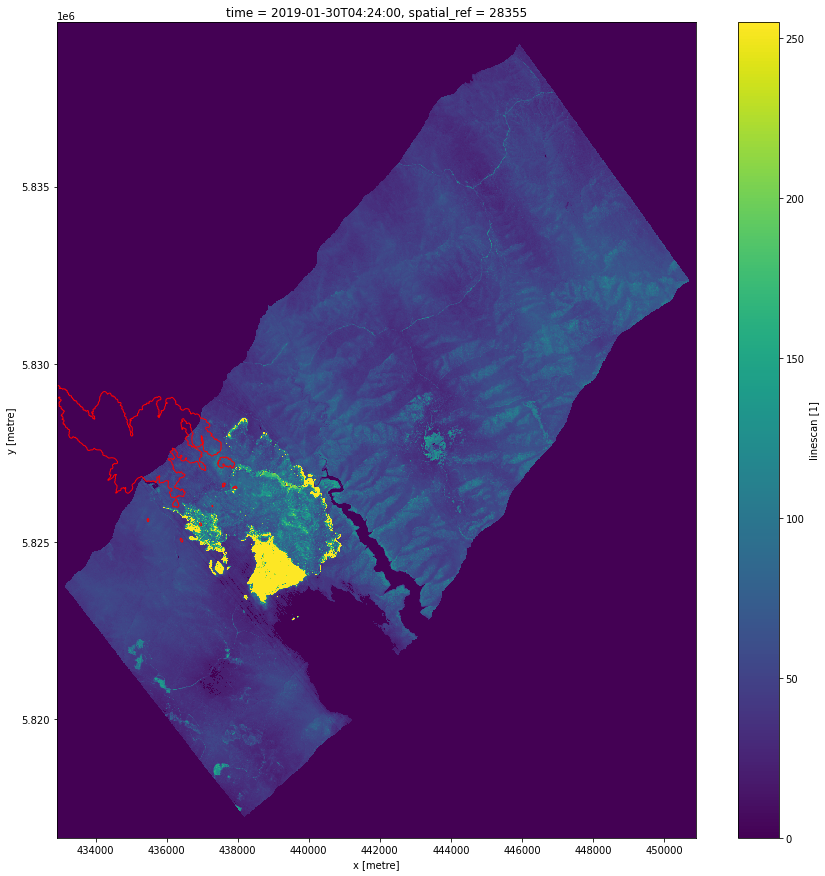

In [15]:

# 2-1. Find the closest image from train set()
b1  = gdf[gdf.SourceNameClean == 'JORDAN_264_P1_201901301524_MGA94_55']
src1 = dc.load(product='linescan', id=linescan_datasets[33].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src1.linescan.plot(ax=ax)
ob1.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

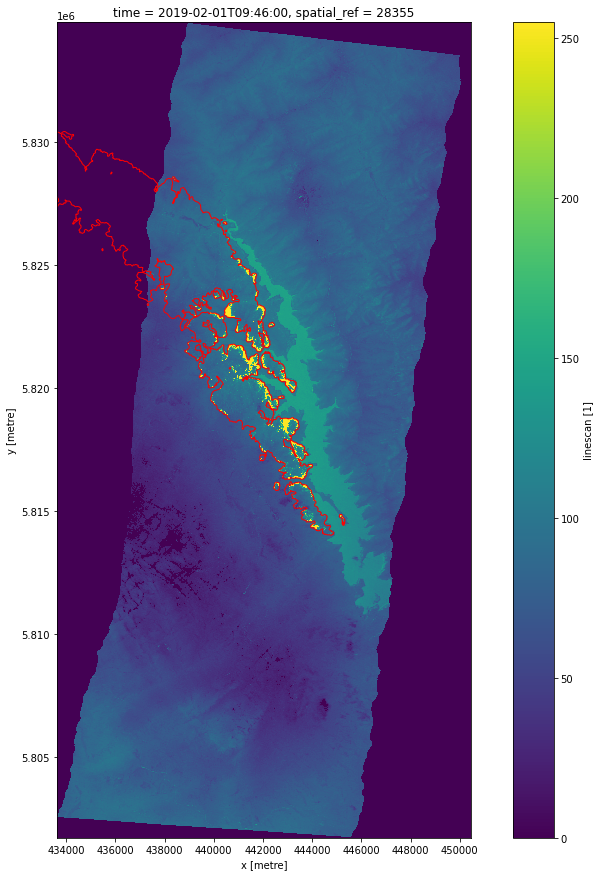

In [16]:

# 2-2. Find the closest image from train set()

ob3  = gdf[gdf.SourceNameClean == 'JORDAN_310_P1_201902012046_MGA94_55']
src3 = dc.load(product='linescan', id=linescan_datasets[39].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src3.linescan.plot(ax=ax)
ob3.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

In [17]:

# 3. Rasterize the train image
tgt = xr_rasterize(gdf=ob1, da=src1)
rgb_mask1=tgt*255
src1['rgb_mask1']=rgb_mask1

tgt2 = xr_rasterize(gdf=ob3, da=src3)
rgb_mask2=tgt2*255
src3['rgb_mask2']=rgb_mask2


Rasterizing to match xarray.DataArray dimensions (2295, 1799)
Rasterizing to match xarray.DataArray dimensions (3314, 1683)


In [18]:
# 4. Extract points where is brighter than 100 from test data

lowerBound=100
upperBound=255
#create the mask over the top of our original image
rgb_mask3 = cv2.inRange(src2.linescan.values[0],lowerBound,upperBound)
colname = src2.x.values
rowname = src2.y.values
rgb_mask3 = pd.DataFrame(rgb_mask3, index = rowname, columns = colname)
rgb_mask3.shape
rgb_mask3.index.name = 'y'
rgb_mask3.columns.name = 'x'
src2['rgb_mask3'] = rgb_mask3

In [19]:
# 5. Overlap the train image on train data.
#Combine into one dataframe
dftest=pd.concat([src1.to_dataframe().reset_index(), src2.to_dataframe().reset_index(), src3.to_dataframe().reset_index()], ignore_index=True, sort=False)
dftest['rgb_mask4']=np.fmax(np.fmax(dftest.loc[:,'rgb_mask1'], dftest.loc[:,'rgb_mask3']),dftest.loc[:,'rgb_mask2'])
newdf=dftest.drop(columns=['time','linescan','spatial_ref','rgb_mask1','rgb_mask2', 'rgb_mask3'], axis=1)

dates = '2019-03-5~6'
x = newdf.x
y = newdf.y
rgb_mask = newdf.rgb_mask4
df_multiindex = pd.DataFrame({'time': dates,
                              'x': x,
                              'y': y,
                              'linescan': rgb_mask})
df_multiindex = df_multiindex.set_index(['time', 'x','y'])



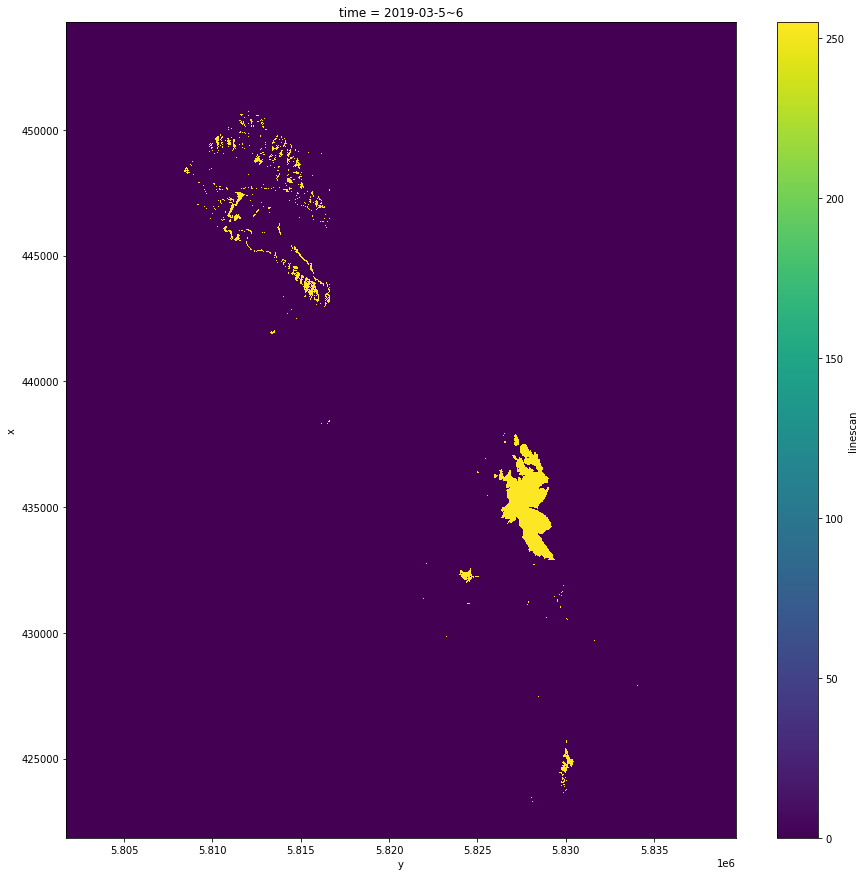

In [20]:
#Plot of overlapped data
rgb_mask=df_multiindex[~df_multiindex.index.duplicated()].to_xarray()
rgb_mask=rgb_mask.fillna(value=0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
rgb_mask.linescan.plot(ax=ax)


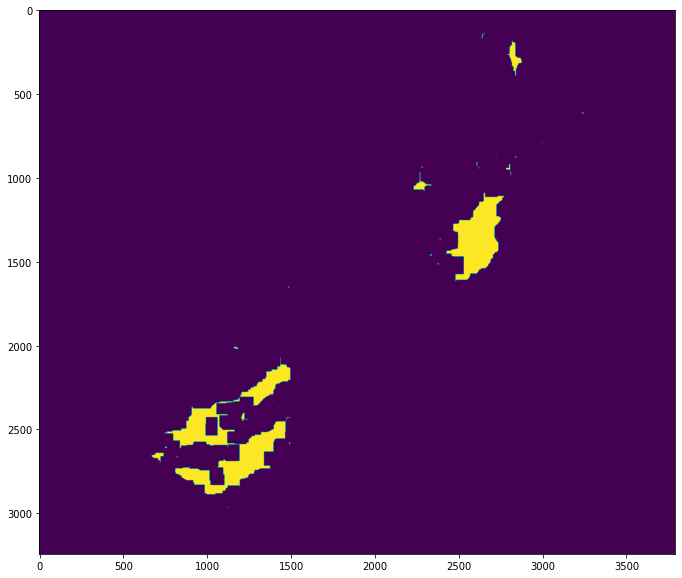

In [21]:

# 6. Mask the overlapped image to get the prediction

#establish dialation and contraction parameters
kernelOpen=np.ones((2,2)) # try it yourself!
kernelClose=np.ones((64,64))    

#denoise the pixels
maskOpen=cv2.morphologyEx(rgb_mask.linescan[0].values,cv2.MORPH_OPEN,kernelOpen)

#join the pxels together
maskClose=cv2.morphologyEx(maskOpen,cv2.MORPH_CLOSE,kernelClose)

fig = plt.figure(figsize=(20, 10))
plt.imshow(maskClose)
plt.show()


In [22]:
# 7. Extract the required points for test set

mask = maskClose/255
our_mask = rgb_mask.linescan
our_mask.values[0] = mask

file_stem='JORDAN_294_P1_201902011150_MGA94_55'
# iterate over the coordinates that are required for testing in the current linescan file
for idx, ob in test.loc[test.label==file_stem].iterrows():
    result_tf = our_mask.sel(x=ob.x, y=ob.y, method='nearest').values[0]
    result_10 = int(result_tf == True)
    test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10

# Test 3

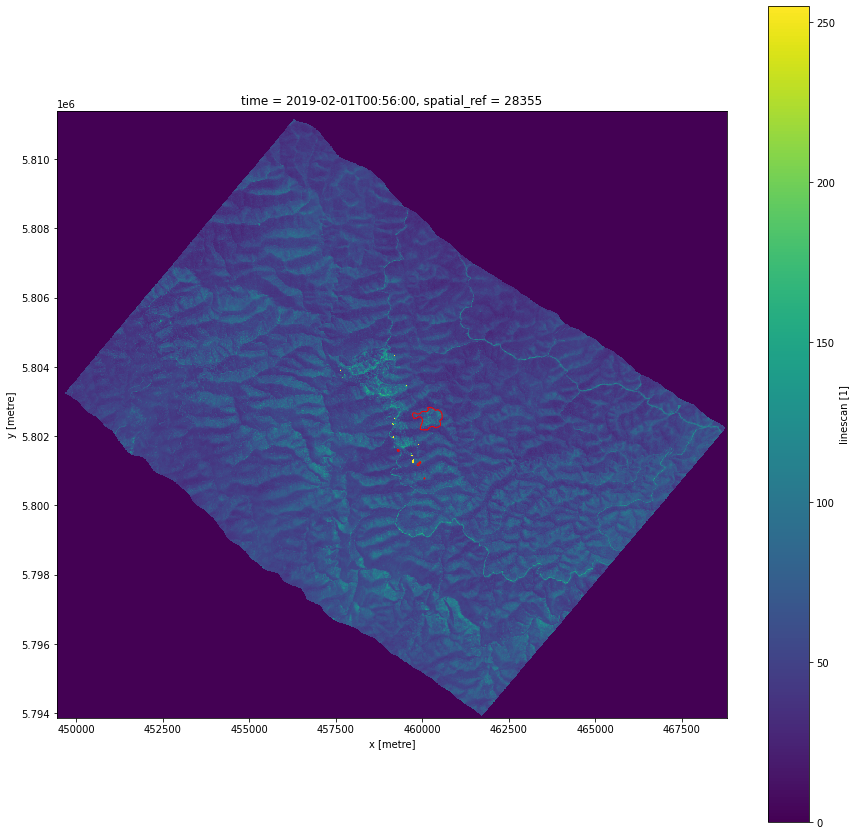

In [23]:
####### Create mask for the first test image. 
# 1. Plot test image
# 2. Find the closest image from train set()
# 3. Rasterize the train image
# 4. Extract points where is brighter than 150 from test data
# 5. Overlap the train image on train data.
# 6. Mask the overlapped image to get the prediction
# 7. Extract the required points for test set

# 2. Find the closest image from train set()
ob1  = gdf[gdf.SourceNameClean == 'WALHALLA_295_P1_201902011156_MGA94_55']
src1 = dc.load(product='linescan', id=linescan_datasets[38].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src1.linescan.plot(ax=ax)
ob1.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

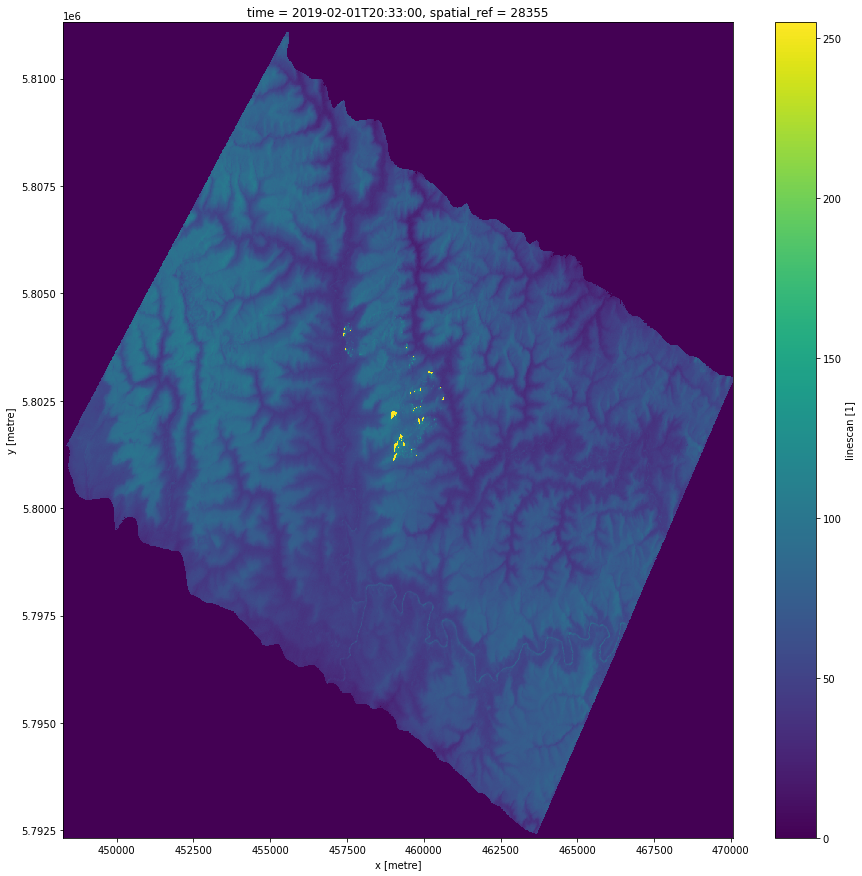

In [24]:
# 1. Plot test image
ob2  = gdf[gdf.SourceNameClean == 'WALHALLA_313_P1_201902020733_MGA94_55']
src2 = dc.load(product='linescan', id=linescan_datasets[40].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src2.linescan.plot(ax=ax)


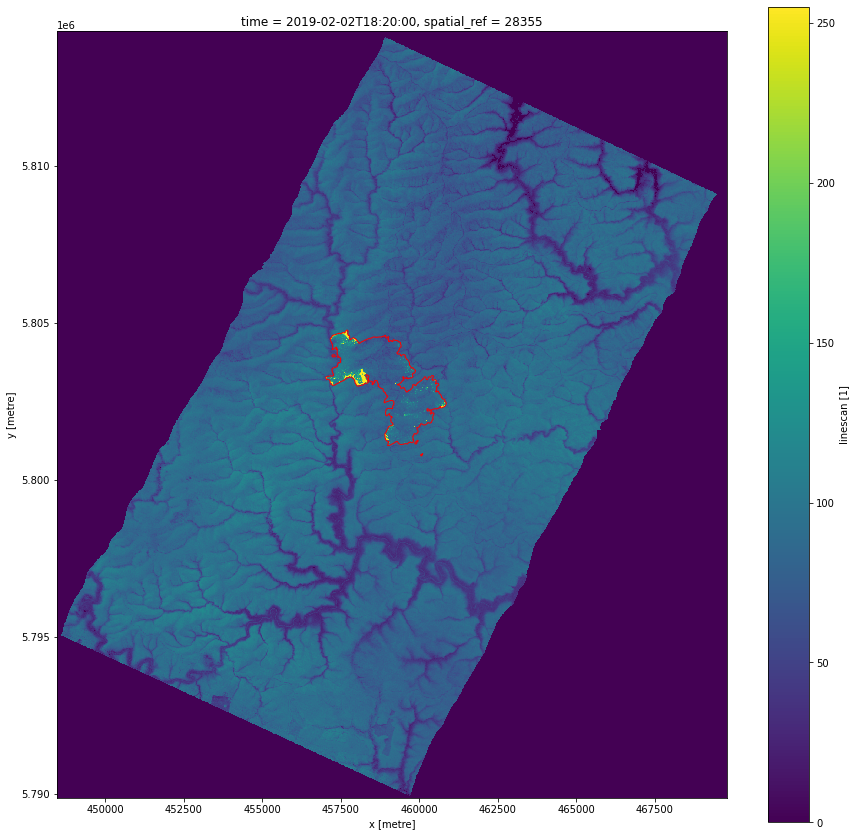

In [25]:
# 2. Find the closest image from train set()

ob3  = gdf[gdf.SourceNameClean == 'WALHALLA_339_P1_201902030520_MGA94_55']
src3 = dc.load(product='linescan', id=linescan_datasets[41].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src3.linescan.plot(ax=ax)
ob3.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

Rasterizing to match xarray.DataArray dimensions (2440, 2132)


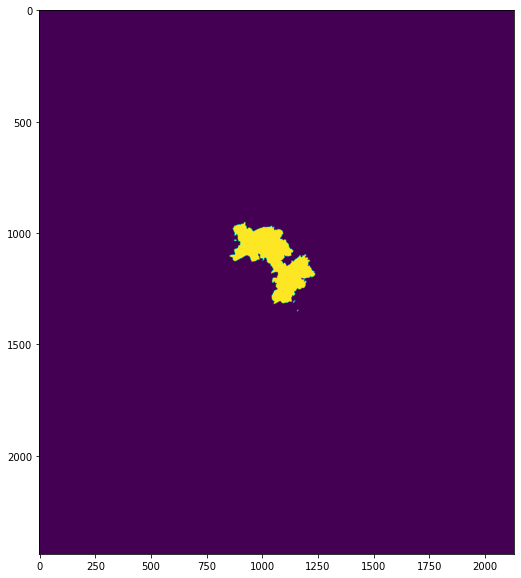

In [26]:
# 3. Rasterize the train image
tgt = xr_rasterize(gdf=ob3, da=src3)
rgb_mask1=tgt*255
src3['rgb_mask1']=rgb_mask1
fig = plt.figure(figsize=(20, 10))
plt.imshow(tgt)
plt.show()

In [27]:
# 4. Extract points where is brighter than 100 from test data

lowerBound=100
upperBound=255
#create the mask over the top of our original image
rgb_mask2 = cv2.inRange(src2.linescan.values[0],lowerBound,upperBound)
colname = src2.x.values
rowname = src2.y.values
rgb_mask2 = pd.DataFrame(rgb_mask2, index = rowname, columns = colname)
rgb_mask2.shape
rgb_mask2.index.name = 'y'
rgb_mask2.columns.name = 'x'
src2['rgb_mask2'] = rgb_mask2

In [28]:
# 5. Overlap the train image on train data.

dftest=pd.concat([src2.to_dataframe().reset_index(), src3.to_dataframe().reset_index()], ignore_index=True, sort=False)
dftest['rgb_mask4']=np.fmax(dftest.loc[:,'rgb_mask1'], dftest.loc[:,'rgb_mask2'])
newdf=dftest.drop(columns=['time','linescan','spatial_ref','rgb_mask1', 'rgb_mask2'], axis=1)

dates = '2019-02-1~2'
x = newdf.x
y = newdf.y
rgb_mask = newdf.rgb_mask4
df_multiindex = pd.DataFrame({'time': dates,
                              'x': x,
                              'y': y,
                              'linescan': rgb_mask})
df_multiindex = df_multiindex.set_index(['time', 'x','y'])

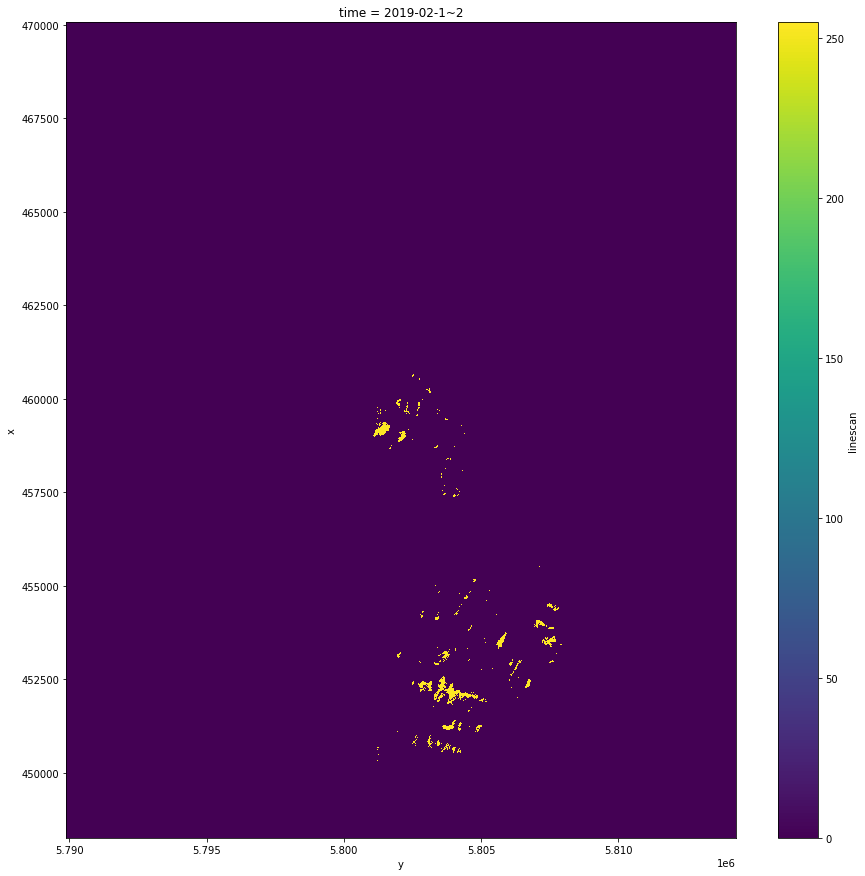

In [29]:

rgb_mask=df_multiindex[~df_multiindex.index.duplicated()].to_xarray()
rgb_mask=rgb_mask.fillna(value=0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
rgb_mask.linescan.plot(ax=ax)

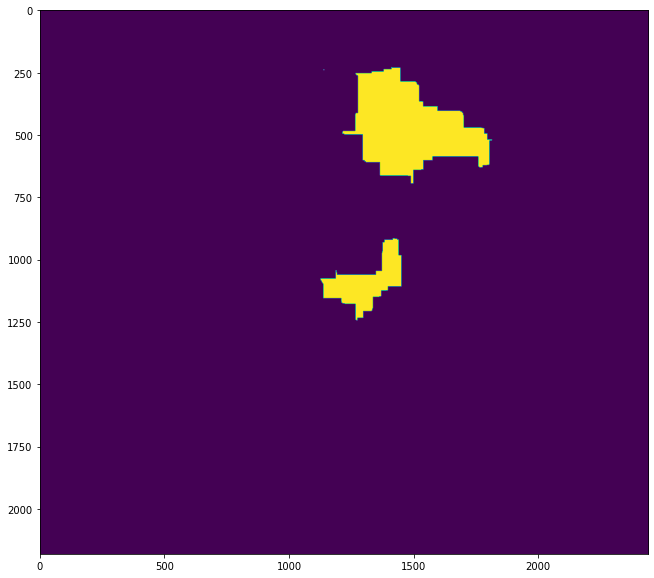

In [30]:
####### Create mask for the first test image. 
# 6. Mask the overlapped image to get the prediction

#establish dialation and contraction parameters
kernelOpen=np.ones((2,2)) # try it yourself!
kernelClose=np.ones((150,150))    

#denoise the pixels
maskOpen=cv2.morphologyEx(rgb_mask.linescan[0].values,cv2.MORPH_OPEN,kernelOpen)
#join the pxels together
maskClose=cv2.morphologyEx(maskOpen,cv2.MORPH_CLOSE,kernelClose)

fig = plt.figure(figsize=(20, 10))
plt.imshow(maskClose)
plt.show()


In [31]:
# 7. Extract the required points for test set

mask = maskClose/255
our_mask = rgb_mask.linescan
our_mask.values[0] = mask

## mask to coordinates
file_stem='WALHALLA_313_P1_201902020733_MGA94_55'
# iterate over the coordinates that are required for testing in the current linescan file
for idx, ob in test.loc[test.label==file_stem].iterrows():
    result_tf = our_mask.sel(x=ob.x, y=ob.y, method='nearest').values[0]
    result_10 = int(result_tf == True)
    test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10

# Test4

/env/lib/python3.6/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


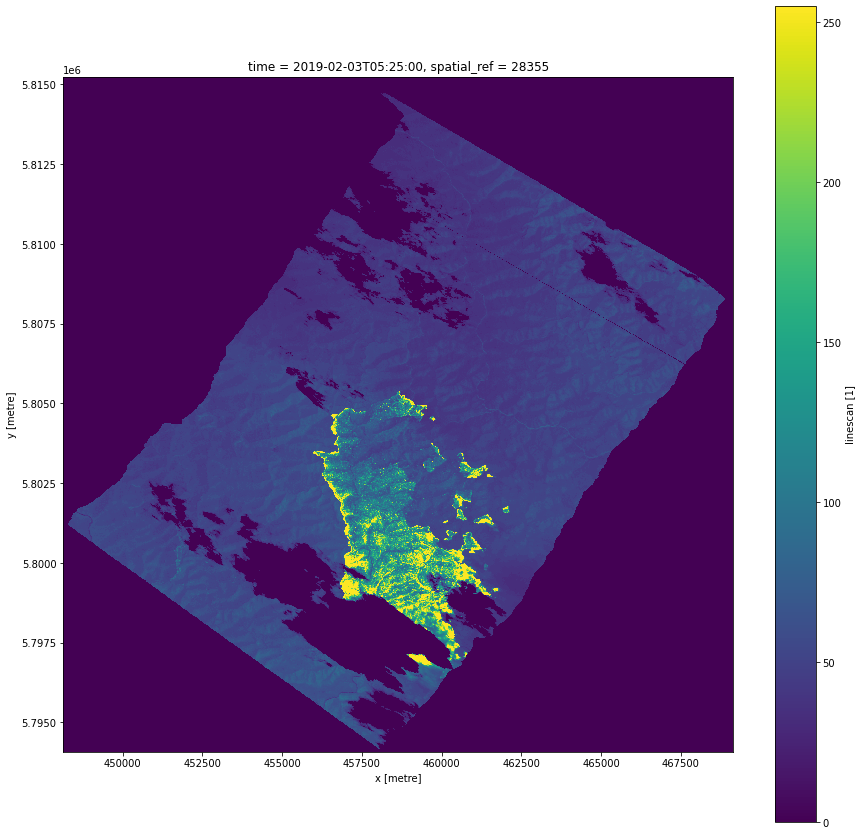

In [32]:
####### Create mask for the first test image. 
# 1. Plot test image
# 2. (Did not used train image since the test image was clear)
# 3. Rasterize the train image
# 4. Extract points where is brighter than 150 from test data
# 5. (Did not used train image since the test image was clear)
# 6. Mask the overlapped image to get the prediction
# 7. Extract the required points for test set

ob1  = gdf[gdf.SourceNameClean == 'WALHALLA_353_P1_201902031625_MGA94_55']
src1 = dc.load(product='linescan', id=linescan_datasets[44].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src1.linescan.plot(ax=ax)
ob1.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

In [33]:

# 4. Extract points where is brighter than 100 from test data

lowerBound=100
upperBound=255
#create the mask over the top of our original image
rgb_mask2 = cv2.inRange(src1.linescan.values[0],lowerBound,upperBound)
colname = src1.x.values
rowname = src1.y.values
rgb_mask2 = pd.DataFrame(rgb_mask2, index = rowname, columns = colname)
rgb_mask2.shape
rgb_mask2.index.name = 'y'
rgb_mask2.columns.name = 'x'
src1['rgb_mask2'] = rgb_mask2

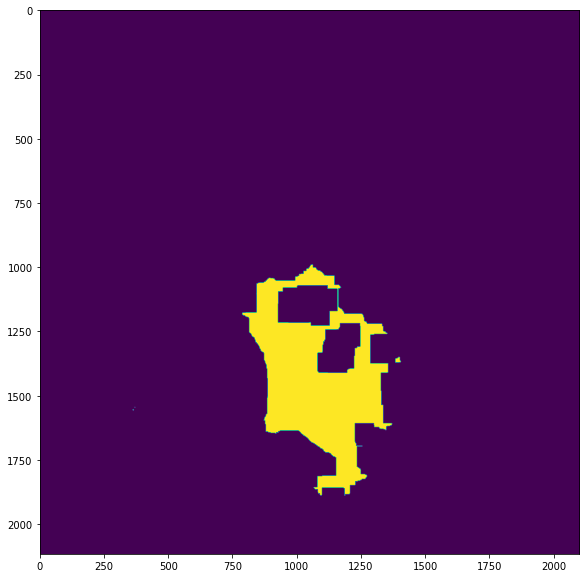

In [34]:

# 6. Mask the overlapped image to get the prediction


#establish dialation and contraction parameters
kernelOpen=np.ones((2,2)) # try it yourself!
kernelClose=np.ones((70,70))    

#denoise the pixels
maskOpen=cv2.morphologyEx(src1.rgb_mask2.values,cv2.MORPH_OPEN,kernelOpen)
#join the pxels together
maskClose=cv2.morphologyEx(maskOpen,cv2.MORPH_CLOSE,kernelClose)

fig = plt.figure(figsize=(20, 10))
plt.imshow(maskClose)
plt.show()


In [35]:

# 7. Extract the required points for test set

mask = maskClose/255
our_mask = src1.linescan
our_mask.values[0] = mask

file_stem =  'WALHALLA_353_P1_201902031625_MGA94_55'

## mask to coordinates
# iterate over the coordinates that are required for testing in the current linescan file
for idx, ob in test.loc[test.label==file_stem].iterrows():
    result_tf = our_mask.sel(x=ob.x, y=ob.y, method='nearest').values[0]
    result_10 = int(result_tf == True)
    test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10

# Test 5

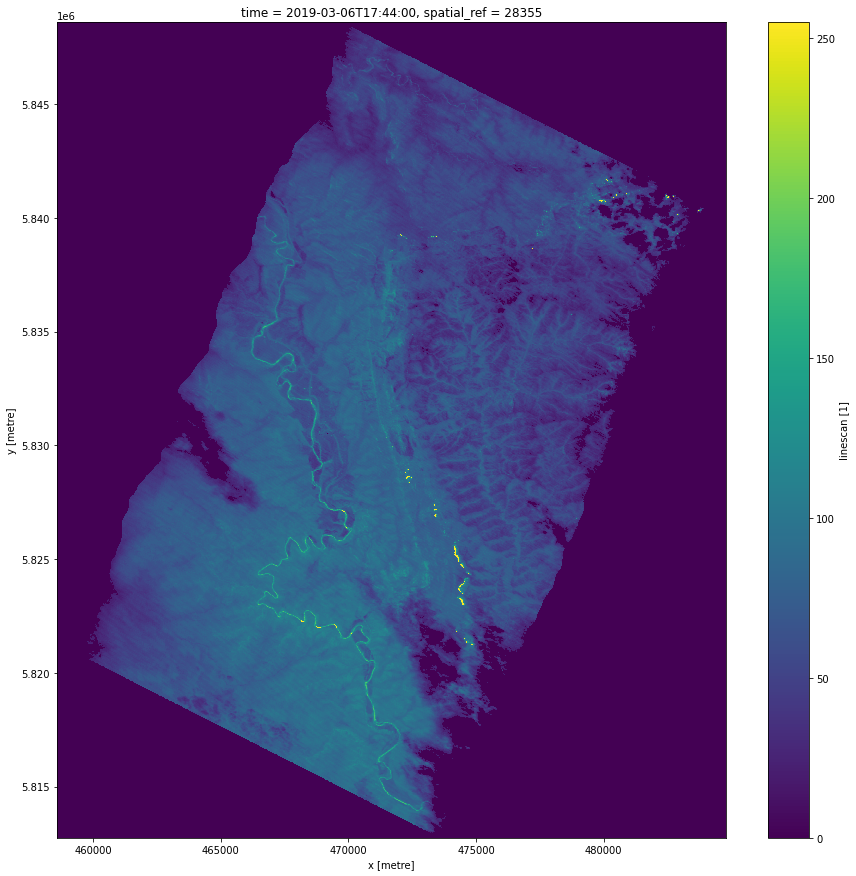

In [36]:
####### Create mask for the first test image. 
# 1. Plot test image
# 2. Find the closest image from train set()
# 3. Rasterize the train image and extracted points where is brighter than 150 from train data
# 4. Extract points where is brighter than 150 from test data
# 5. Overlap the train image on train data.
# 6. Mask the overlapped image to get the prediction
# 7. Extract the required points for test set

# 1. Plot test image

ob2  = gdf[gdf.SourceNameClean == 'MACALISTER91_648_P1_201903070444_MGA94_55']
src2 = dc.load(product='linescan', id=linescan_datasets[76].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src2.linescan.plot(ax=ax)
#ob1.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

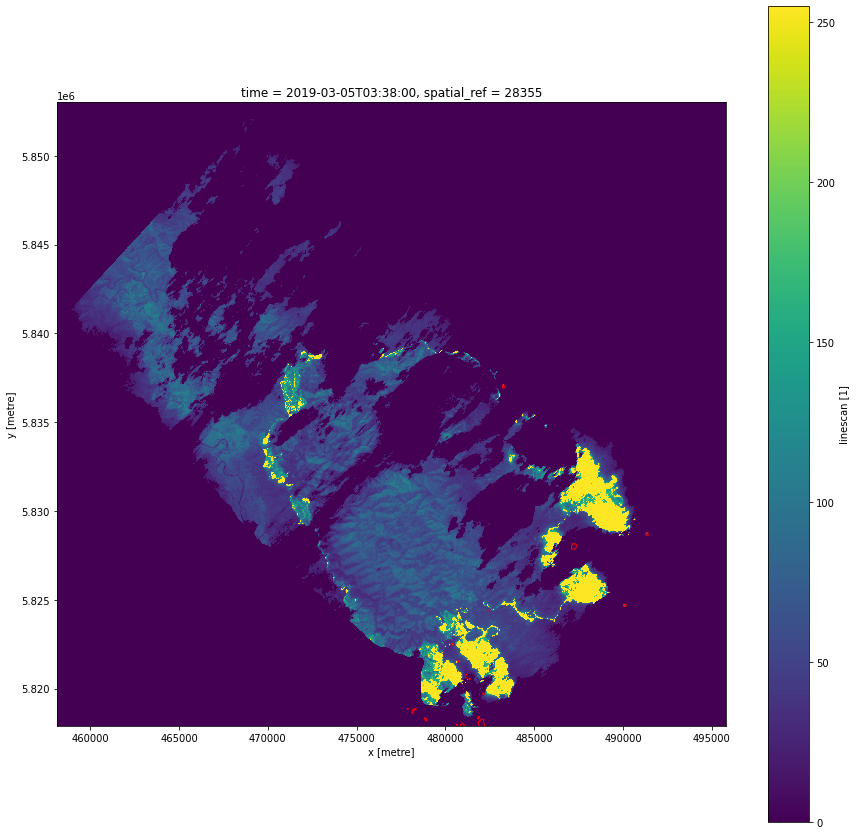

In [37]:

# 3. Rasterize the train image and extracted points where is brighter than 150 from train data

ob1  = gdf[gdf.SourceNameClean == 'MACALISTER91_615_P1_201903051438_MGA94_55']
src1 = dc.load(product='linescan', id=linescan_datasets[65].id, output_crs='epsg:28355', resolution=(-10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src1.linescan.plot(ax=ax)
ob1.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

In [38]:
# 3. Rasterize the train image and extracted points where is brighter than 100 from train data

tgt = xr_rasterize(gdf=ob1, da=src1)
rgb_mask1=tgt*255
src1['rgb_mask1']=rgb_mask1


Rasterizing to match xarray.DataArray dimensions (3509, 3770)


In [39]:

lowerBound=100
upperBound=255
#create the mask over the top of our original image
rgb_mask2 = cv2.inRange(src1.linescan.values[0],lowerBound,upperBound)
colname = src1.x.values
rowname = src1.y.values
rgb_mask2 = pd.DataFrame(rgb_mask2, index = rowname, columns = colname)
rgb_mask2.shape
rgb_mask2.index.name = 'y'
rgb_mask2.columns.name = 'x'
src1['rgb_mask2'] = rgb_mask2

In [40]:
# 4. Extract points where is brighter than 100 from test data

lowerBound=100
upperBound=255
#create the mask over the top of our original image
rgb_mask3 = cv2.inRange(src2.linescan.values[0],lowerBound,upperBound)
colname = src2.x.values
rowname = src2.y.values
rgb_mask3 = pd.DataFrame(rgb_mask3, index = rowname, columns = colname)
rgb_mask3.shape
rgb_mask3.index.name = 'y'
rgb_mask3.columns.name = 'x'
src2['rgb_mask3'] = rgb_mask3

In [41]:

# 5. Overlap the train image on train data.

dftest=pd.concat([src1.to_dataframe().reset_index(), src2.to_dataframe().reset_index()], ignore_index=True, sort=False)
dftest['rgb_mask4']=np.fmax(np.fmax(dftest.loc[:,'rgb_mask1'], dftest.loc[:,'rgb_mask2']), dftest.loc[:,'rgb_mask3'])
newdf=dftest.drop(columns=['time','linescan','spatial_ref','rgb_mask1', 'rgb_mask2', 'rgb_mask3'], axis=1)

dates = '2019-03-5~6'
x = newdf.x
y = newdf.y
rgb_mask = newdf.rgb_mask4
df_multiindex = pd.DataFrame({'time': dates,
                              'x': x,
                              'y': y,
                              'linescan': rgb_mask})
df_multiindex = df_multiindex.set_index(['time', 'x','y'])

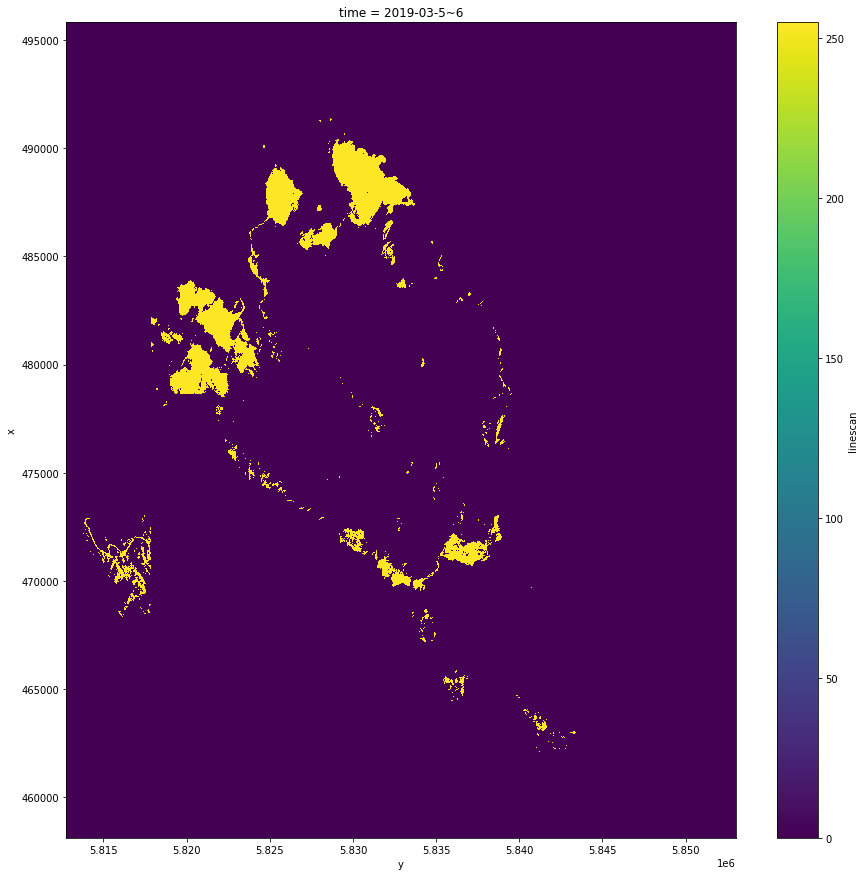

In [42]:



rgb_mask=df_multiindex[~df_multiindex.index.duplicated()].to_xarray()
rgb_mask=rgb_mask.fillna(value=0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
rgb_mask.linescan.plot(ax=ax)

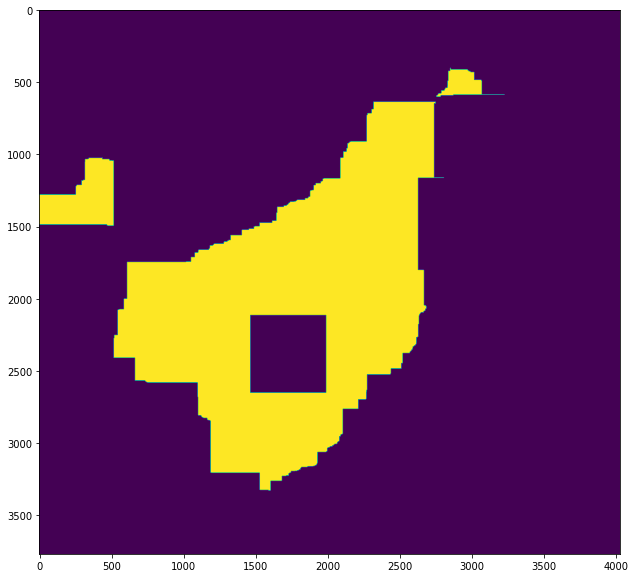

In [43]:

# 6. Mask the overlapped image to get the prediction

#establish dialation and contraction parameters
kernelOpen=np.ones((2,2)) # try it yourself!
kernelClose=np.ones((500,500))    

#denoise the pixels
maskOpen=cv2.morphologyEx(rgb_mask.linescan[0].values,cv2.MORPH_OPEN,kernelOpen)

#join the pxels together
maskClose=cv2.morphologyEx(maskOpen,cv2.MORPH_CLOSE,kernelClose)

fig = plt.figure(figsize=(20, 10))
plt.imshow(maskClose)
plt.show()


In [ ]:
# 7. Extract the required points for test set

mask = maskClose/255
our_mask = rgb_mask.linescan
our_mask.values[0] = mask

file_stem='MACALISTER91_648_P1_201903070444_MGA94_55'
## mask to coordinates
# iterate over the coordinates that are required for testing in the current linescan file
for idx, ob in test.loc[test.label==file_stem].iterrows():
    result_tf = our_mask.sel(x=ob.x, y=ob.y, method='nearest').values[0]
    result_10 = int(result_tf == True)
    test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10

## Write out the data into csv file

In [ ]:
test.target.value_counts()

test.to_csv('my_challenge1_submission.csv', columns = ['target'])
test.head()


In [ ]:
test